In [ ]:
#!pip install pytorch-lightning --quiet
#!pip install transformers --quiet
#!pip install accelerate --quiet
#!pip install pytorch-forecasting --quiet
#!pip install arch --quiet
#!pip install zarr --quiet
#!pip install pandas==2.2.3 --quiet
#!pip install xarray --quiet
#!pip install h5py -- quiet
#!pip install xgboost -- quiet
#!pip install seaborn pandas scikit-learn matplotlib -- quiet
#!pip install boto3 -- quiet
#!pip install pyod -- quiet
#!pip install numpy==2.1.0

In [ ]:
# --- Standard Library Imports ---
import os
import gc
import math
import copy
import random
import re
import zarr
import time
import subprocess
import pickle
import heapq
from functools import partial
from itertools import combinations, count, product
from datetime import datetime
from scipy.stats import loguniform
from pandas.tseries.offsets import DateOffset
import glob
import xgboost as xgb

# --- Data Handling & Numerical Operations ---
import numpy as np
import pandas as pd

# --- PyTorch & PyTorch Lightning (for TFT) ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

# --- Scikit-learn (CPU-based) ---
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import RFECV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from scipy.stats import truncnorm
from scipy.stats import norm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM



# --- Parallel Processing ---
from joblib import Parallel, delayed, parallel_backend

# --- Plotting & Visualization ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

# --- Other Utilities ---
import boto3 # For AWS S3 interaction
from scipy.optimize import differential_evolution
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import truncnorm


# Seed & device
SEED = 42
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/najo1o11/najo1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Define the path to your CSV file
file_path = '/home/jonathan.muwanguzi/df_features4.csv'

# Import the CSV file, parsing 'DateTime' as dates and setting it as the index
df_feat = pd.read_csv(file_path, parse_dates=['DateTime'], index_col='DateTime')

# Display the first few rows of the DataFrame to verify
df_feat

In [ ]:
df_feat['netload_pers']  = df_feat['IE Demand'] - df_feat['pers_1h']
df_feat['netload_arima'] = df_feat['IE Demand'] - df_feat['arima_garch_1h']
df_feat['netload_exp']   = df_feat['IE Demand'] - df_feat['exp_mean_1h']

df_feat['resid_pers']    = df_feat['Net_load'] - df_feat['netload_pers']
df_feat['resid_arima']   = df_feat['Net_load'] - df_feat['netload_arima']
df_feat['resid_exp']     = df_feat['Net_load'] - df_feat['netload_exp']

In [ ]:
df_feat.shape

(397145, 31)

In [ ]:
df_feat.columns

Index(['IE Generation', 'IE Demand', 'IE Wind Availability',
       'IE Wind Generation', 'SNSP', 'interconnection', 'NW_temp', 'NW_wdsp',
       'NW_wddir', 'NE_temp', 'NE_wdsp', 'NE_wddir', 'SW_temp', 'SW_wdsp',
       'SW_wddir', 'SE_temp', 'SE_wdsp', 'SE_wddir', 'Net_load', 'pers_1h',
       'arima_mean_1h', 'garch_var_1h', 'arima_garch_1h', 'exp_mean_1h',
       'exp_var_1h', 'resid_pers', 'resid_arima', 'resid_exp', 'netload_pers',
       'netload_arima', 'netload_exp'],
      dtype='object')

In [ ]:
# Cell 1: Define training and hold‑out masks, estimate σ on training residuals
train_mask = df_feat.index < "2023-01-01"
holdout_mask = df_feat.index >= "2023-01-01"

# Estimate σ on the training set using the exponential‑smoothing residuals
sigma_exp = df_feat.loc[train_mask, 'resid_exp'].std()
print(f"Estimated σ (resid_exp) on 2014–2022: {sigma_exp:.3f}")

Estimated σ (resid_exp) on 2014–2022: 110.673


In [ ]:
# Cell 2: Flag hold‑out anomalies where |resid_exp| > 3·σ
df_feat.loc[holdout_mask, 'anom_sigma'] = (
    df_feat.loc[holdout_mask, 'resid_exp'].abs() > 3 * sigma_exp
).astype(int)

# Inspect the first few flagged rows
df_feat.loc[holdout_mask, ['resid_exp', 'anom_sigma']].head(10)

,resid_exp,anom_sigma
DateTime,,
2023-01-01 00:00:00,-3.67884,0.0
2023-01-01 00:15:00,-31.09884,0.0
2023-01-01 00:30:00,-37.88884,0.0
2023-01-01 00:45:00,-68.40884,0.0
2023-01-01 01:00:00,-120.15884,0.0
2023-01-01 01:15:00,-160.61884,0.0
2023-01-01 01:30:00,-146.24884,0.0
2023-01-01 01:45:00,-160.33884,0.0
2023-01-01 02:00:00,-171.08884,0.0


In [ ]:
# Cell 3: Compute false‑alarm rate on the hold‑out period
fa_rate = df_feat.loc[holdout_mask, 'anom_sigma'].mean()
print(f"False‑alarm rate (σ‑threshold) on 2023–2024 hold‑out: {fa_rate:.3%}")

False‑alarm rate (σ‑threshold) on 2023–2024 hold‑out: 69.332%


In [ ]:
# Calculate the sum of NaN values for each column
nan_counts_per_column = df_feat.isnull().sum()

print("\nColumns with NaN values:")
print(nan_counts_per_column[nan_counts_per_column > 0])


Columns with NaN values:
anom_sigma    315544
dtype: int64


In [ ]:
df_feat['anom_sigma'] = df_feat['anom_sigma'].fillna(0).astype(int)

In [ ]:
# Calculate the sum of NaN values for each column
nan_counts_per_column = df_feat.isnull().sum()

print("\nColumns with NaN values:")
print(nan_counts_per_column[nan_counts_per_column > 0])


Columns with NaN values:
Series([], dtype: int64)


In [ ]:
# Cell 1: Fit Isolation Forest on training residuals
from sklearn.ensemble import IsolationForest

# Prepare data
X_train_if = df_feat.loc[train_mask, ['resid_exp']]

# Initialize and fit
if_model = IsolationForest(contamination=0.05, random_state=SEED)
if_model.fit(X_train_if);

In [ ]:
# Cell 2: Predict on hold‑out and map to anomaly flag
X_holdout_if = df_feat.loc[holdout_mask, ['resid_exp']]

# IsolationForest.predict yields 1 for inliers, -1 for outliers
pred_if = if_model.predict(X_holdout_if)

# Map to 0/1 anomaly indicator
df_feat.loc[holdout_mask, 'anom_if'] = (pred_if == -1).astype(int)

# Preview
df_feat.loc[holdout_mask, ['resid_exp', 'anom_if']].head(10)

,resid_exp,anom_if
DateTime,,
2023-01-01 00:00:00,-3.67884,0.0
2023-01-01 00:15:00,-31.09884,0.0
2023-01-01 00:30:00,-37.88884,0.0
2023-01-01 00:45:00,-68.40884,0.0
2023-01-01 01:00:00,-120.15884,0.0
2023-01-01 01:15:00,-160.61884,0.0
2023-01-01 01:30:00,-146.24884,0.0
2023-01-01 01:45:00,-160.33884,0.0
2023-01-01 02:00:00,-171.08884,0.0


In [ ]:
# Cell 3: Evaluate Precision, Recall, F1 against σ‑threshold proxy labels
from sklearn.metrics import precision_score, recall_score, f1_score

# Use σ‑threshold flags as pseudo ground truth
y_true = df_feat.loc[holdout_mask, 'anom_sigma']
y_pred = df_feat.loc[holdout_mask, 'anom_if']

prec_if   = precision_score(y_true, y_pred, zero_division=0)
recall_if = recall_score(y_true, y_pred, zero_division=0)
f1_if     = f1_score(y_true, y_pred, zero_division=0)

print(f"Isolation Forest — Precision: {prec_if:.3f}, Recall: {recall_if:.3f}, F1: {f1_if:.3f}")

Isolation Forest — Precision: 0.891, Recall: 1.000, F1: 0.942


In [ ]:
# Cell 1: Fit One‑Class SVM on training residuals
from sklearn.svm import OneClassSVM

# Prepare training data as a 2D array
X_train_ocsvm = df_feat.loc[train_mask, ['resid_exp']]

# Initialize and fit
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm.fit(X_train_ocsvm)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.05
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [ ]:
# Cell 2: Predict on hold‑out and map to anomaly flag
X_holdout_ocsvm = df_feat.loc[holdout_mask, ['resid_exp']]

# OneClassSVM.predict returns 1 for inliers, -1 for outliers
pred_oc = ocsvm.predict(X_holdout_ocsvm)

# Map to 0/1 anomaly indicator
df_feat.loc[holdout_mask, 'anom_ocsvm'] = (pred_oc == -1).astype(int)

# Preview first few predictions
df_feat.loc[holdout_mask, ['resid_exp', 'anom_ocsvm']].head(10)

,resid_exp,anom_ocsvm
DateTime,,
2023-01-01 00:00:00,-3.67884,0.0
2023-01-01 00:15:00,-31.09884,0.0
2023-01-01 00:30:00,-37.88884,0.0
2023-01-01 00:45:00,-68.40884,0.0
2023-01-01 01:00:00,-120.15884,0.0
2023-01-01 01:15:00,-160.61884,0.0
2023-01-01 01:30:00,-146.24884,0.0
2023-01-01 01:45:00,-160.33884,0.0
2023-01-01 02:00:00,-171.08884,0.0


In [ ]:
# Cell 3: Evaluate OC‑SVM against σ‑threshold proxy labels
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = df_feat.loc[holdout_mask, 'anom_sigma']
y_pred = df_feat.loc[holdout_mask, 'anom_ocsvm']

prec_oc   = precision_score(y_true, y_pred, zero_division=0)
recall_oc = recall_score(y_true, y_pred, zero_division=0)
f1_oc     = f1_score(y_true, y_pred, zero_division=0)

print(f"One‑Class SVM — Precision: {prec_oc:.3f}, Recall: {recall_oc:.3f}, F1: {f1_oc:.3f}")

One‑Class SVM — Precision: 0.944, Recall: 1.000, F1: 0.971


In [ ]:
# Cell 1: Prepare training & hold‑out arrays for Deep SVDD

# 1) Extract residuals as 2‑D arrays (n_samples × 1)
X_train = df_feat.loc[train_mask, 'resid_exp'].values.reshape(-1, 1)
X_hold  = df_feat.loc[holdout_mask, 'resid_exp'].values.reshape(-1, 1)

# 2) Proxy labels for evaluation
y_hold_true = df_feat.loc[holdout_mask, 'anom_sigma'].values

In [ ]:
# Cell 2: Train Deep SVDD and compute a distance threshold
from pyod.models.deep_svdd import DeepSVDD
import numpy as np

# 1) Instantiate DeepSVDD — small network since it's 1‑D input
svdd = DeepSVDD(
    n_features=1,              # specify number of input dimensions
    hidden_neurons=[32, 16],
    epochs=50,
    batch_size=256,
    contamination=0.05,        # initial guess; we'll pick threshold manually
    verbose=1
)

# 2) Fit on 2014–2022 residuals
svdd.fit(X_train)

# 3) Get train distances (higher = more anomalous)
train_scores = svdd.decision_scores_

# 4) Choose threshold at the 95th percentile of training scores
threshold = np.percentile(train_scores, 95)
print(f"DeepSVDD threshold (95th pctile of train scores): {threshold:.3f}")

Epoch 1/50, Loss: 460.07823948562145
Epoch 2/50, Loss: 460.09856732189655
Epoch 3/50, Loss: 460.11451560258865
Epoch 4/50, Loss: 460.16097462177277
Epoch 5/50, Loss: 460.0823668539524
Epoch 6/50, Loss: 460.12068223953247
Epoch 7/50, Loss: 460.11654430627823
Epoch 8/50, Loss: 460.0932893306017
Epoch 9/50, Loss: 460.10518541932106
Epoch 10/50, Loss: 460.10868473351
Epoch 11/50, Loss: 460.08629709482193
Epoch 12/50, Loss: 460.11541226506233
Epoch 13/50, Loss: 460.0829564332962
Epoch 14/50, Loss: 460.08859556913376
Epoch 15/50, Loss: 460.06937685608864
Epoch 16/50, Loss: 460.092443972826
Epoch 17/50, Loss: 460.0643529742956
Epoch 18/50, Loss: 460.07687179744244
Epoch 19/50, Loss: 460.05419540405273
Epoch 20/50, Loss: 460.05278995633125
Epoch 21/50, Loss: 460.05237993597984
Epoch 22/50, Loss: 460.05290807783604
Epoch 23/50, Loss: 460.13296891748905
Epoch 24/50, Loss: 460.06815534830093
Epoch 25/50, Loss: 460.0982119590044
Epoch 26/50, Loss: 460.1049577742815
Epoch 27/50, Loss: 460.043825954

In [ ]:
# Cell 3: Score hold‑out, flag anomalies, and evaluate
from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Compute hold‑out scores
hold_scores = svdd.decision_function(X_hold)

# 2) Flag anomalies where score > threshold
y_hold_pred = (hold_scores > threshold).astype(int)

# 3) Evaluate
prec_svdd  = precision_score(y_hold_true, y_hold_pred, zero_division=0)
recall_svdd= recall_score(y_hold_true, y_hold_pred, zero_division=0)
f1_svdd    = f1_score(y_hold_true, y_hold_pred, zero_division=0)

print(f"DeepSVDD — Precision: {prec_svdd:.3f}, Recall: {recall_svdd:.3f}, F1: {f1_svdd:.3f}")

DeepSVDD — Precision: 0.898, Recall: 0.987, F1: 0.941


In [ ]:
# Consolidate all detector metrics into a DataFrame (with all false‑alarm rates)


fa_rate_if = df_feat.loc[holdout_mask, 'anom_if'].mean()

# OC‑SVM false‑alarm rate

fa_rate_ocsvm = df_feat.loc[holdout_mask, 'anom_ocsvm'].mean()

# DeepSVDD false‑alarm rate
df_feat.loc[holdout_mask, 'anom_svdd'] = y_hold_pred
fa_rate_svdd  = df_feat.loc[holdout_mask, 'anom_svdd'].mean()

metrics = [

    {

        'Method': 'σ‑Threshold',

        'FalseAlarmRate': fa_rate,

        'Precision':       np.nan,

        'Recall':          np.nan,

        'F1':              np.nan

    },

    {

        'Method': 'IsolationForest',

        'FalseAlarmRate': fa_rate_if,

        'Precision':      prec_if,

        'Recall':         recall_if,

        'F1':             f1_if

    },

    {

        'Method': 'OC‑SVM',

        'FalseAlarmRate': fa_rate_ocsvm,

        'Precision':      prec_oc,

        'Recall':         recall_oc,

        'F1':             f1_oc

    },

    {

        'Method': 'DeepSVDD',

        'FalseAlarmRate': fa_rate_svdd,

        'Precision':      prec_svdd,

        'Recall':         recall_svdd,

        'F1':             f1_svdd

    }

]

df_detector_metrics = pd.DataFrame(metrics)

df_detector_metrics

,Method,FalseAlarmRate,Precision,Recall,F1
0,σ‑Threshold,0.693325,NaN,NaN,NaN
1,IsolationForest,0.778397,0.890708,1.000000,0.942195
2,OC‑SVM,0.734758,0.943610,1.000000,0.970987
3,DeepSVDD,0.761829,0.898305,0.987062,0.940594


In [ ]:
# Calculate the sum of NaN values for each column
nan_counts_per_column2 = df_feat.isnull().sum()

print("\nColumns with NaN values:")
print(nan_counts_per_column2[nan_counts_per_column2 > 0])


Columns with NaN values:
anom_if       315544
anom_ocsvm    315544
anom_svdd     315544
dtype: int64


In [ ]:
train_mask = df_feat.index < "2023-01-01"
holdout_mask = df_feat.index >= "2023-01-01"

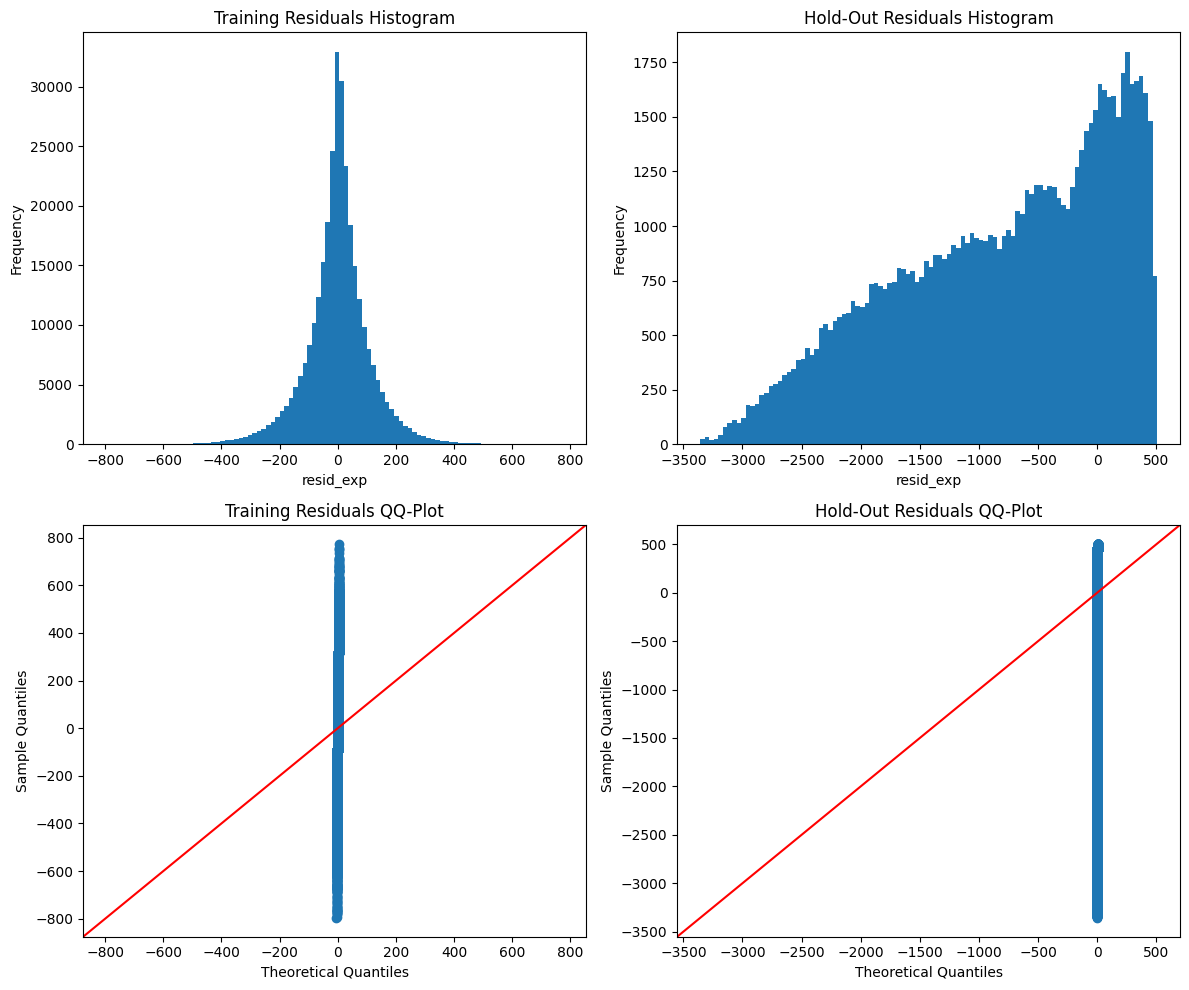

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

# Extract training and hold-out residuals
train_resid = df_feat.loc[train_mask, 'resid_exp']
hold_resid  = df_feat.loc[holdout_mask, 'resid_exp']

# Create 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram: Training residuals
axes[0, 0].hist(train_resid, bins=100)
axes[0, 0].set_title('Training Residuals Histogram')
axes[0, 0].set_xlabel('resid_exp')
axes[0, 0].set_ylabel('Frequency')

# Histogram: Hold-out residuals
axes[0, 1].hist(hold_resid, bins=100)
axes[0, 1].set_title('Hold-Out Residuals Histogram')
axes[0, 1].set_xlabel('resid_exp')
axes[0, 1].set_ylabel('Frequency')

# QQ-plot: Training residuals vs Normal
qqplot(train_resid, line='45', ax=axes[1, 0])
axes[1, 0].set_title('Training Residuals QQ-Plot')

# QQ-plot: Hold-out residuals vs Normal
qqplot(hold_resid, line='45', ax=axes[1, 1])
axes[1, 1].set_title('Hold-Out Residuals QQ-Plot')

plt.tight_layout()
plt.show()

In [ ]:
# 1) copy
df_feat1 = df_feat.copy()

# 2) add year & month
df_feat1['year']  = df_feat1.index.year
df_feat1['month'] = df_feat1.index.month

# 3) map month → season
season_map = {
    12: 'winter', 1: 'winter', 2: 'winter',
     3: 'spring', 4: 'spring', 5: 'spring',
     6: 'summer', 7: 'summer', 8: 'summer',
     9: 'autumn',10: 'autumn',11: 'autumn'
}
df_feat1['season'] = df_feat1['month'].map(season_map)

# 4) restrict to hold‑out period
mask = df_feat1.index >= "2023-01-01"
df_h = df_feat1.loc[mask]

# 5) group and compute metrics
records = []
for (yr, ss), grp in df_h.groupby(['year','season']):
    y_true = grp['anom_sigma']
    y_obs  = grp['anom_ocsvm']
    records.append({
        'year':      yr,
        'season':    ss,
        'n_points':  len(grp),
        'anom_rate': y_obs.mean(),
        'precision': precision_score(y_true, y_obs, zero_division=0),
        'recall':    recall_score(y_true, y_obs, zero_division=0),
        'f1':        f1_score(y_true, y_obs, zero_division=0)
    })

df_period = pd.DataFrame(records)
df_period.set_index(['year','season'], inplace=True)
df_period

n_points  anom_rate  precision  recall        f1
year season                                                  
2023 autumn      8736   0.739125   0.943937     1.0  0.971160
     spring      8832   0.673120   0.936585     1.0  0.967254
     summer      8832   0.630774   0.910250     1.0  0.953016
     winter      8640   0.843171   0.967742     1.0  0.983607
2024 autumn      8736   0.695971   0.941447     1.0  0.969841
     spring      8832   0.715353   0.935897     1.0  0.966887
     summer      8832   0.693388   0.937133     1.0  0.967546
     winter      8736   0.815591   0.962947     1.0  0.981124
2025 spring      5761   0.751779   0.923574     1.0  0.960269
     winter      5664   0.833510   0.964838     1.0  0.982104

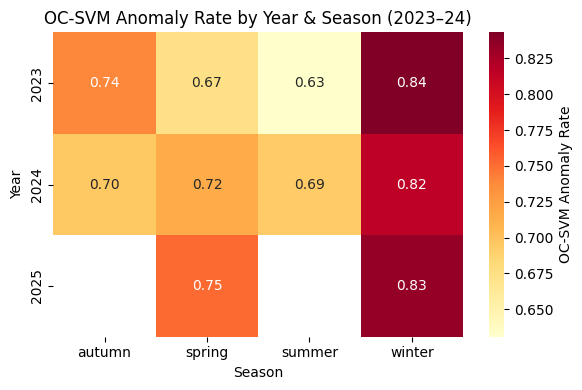

In [ ]:
# Heatmap of anomaly‑rate by year & season

# pivot anomaly rate
pivot_ar = df_period['anom_rate'].unstack()

plt.figure(figsize=(6,4))
sns.heatmap(
    pivot_ar,
    annot=True, fmt=".2f",
    cmap="YlOrRd",
    cbar_kws={'label':'OC‑SVM Anomaly Rate'}
)
plt.title("OC‑SVM Anomaly Rate by Year & Season (2023–24)")
plt.xlabel("Season")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [ ]:
df_seasons = df_feat.copy()
months = df_seasons.index.month
df_seasons['season'] = np.select(
    [months.isin([12,1,2]),
     months.isin([3,4,5]),
     months.isin([6,7,8])],
    ['winter','spring','summer'],
    default='autumn'
)

In [ ]:
winter_resid = df_seasons.loc[df_seasons['season']=='winter', 'resid_exp']
summer_resid = df_seasons.loc[df_seasons['season']=='summer', 'resid_exp']

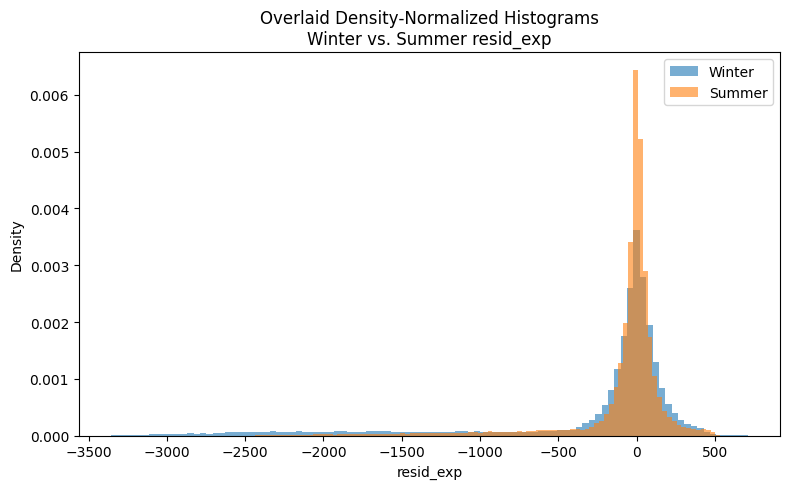

In [ ]:
# Cell: Overlaid normalized histograms of winter vs. summer residuals


# assume winter_resid and summer_resid are already defined
plt.figure(figsize=(8,5))
plt.hist(winter_resid, bins=100, density=True, alpha=0.6, label='Winter', edgecolor='none')
plt.hist(summer_resid, bins=100, density=True, alpha=0.6, label='Summer', edgecolor='none')
plt.title("Overlaid Density‑Normalized Histograms\nWinter vs. Summer resid_exp")
plt.xlabel("resid_exp")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

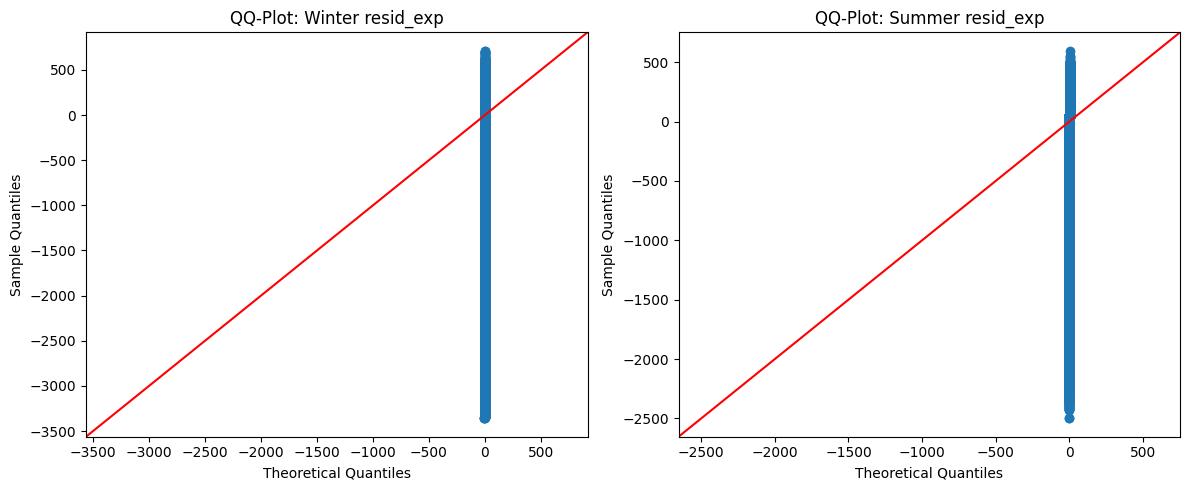

In [ ]:
# Cell: Side‑by‑side QQ‑plots of winter vs. summer residuals
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# QQ‑plot for winter
qqplot(winter_resid, line='45', ax=axes[0])
axes[0].set_title("QQ‑Plot: Winter resid_exp")

# QQ‑plot for summer
qqplot(summer_resid, line='45', ax=axes[1])
axes[1].set_title("QQ‑Plot: Summer resid_exp")

plt.tight_layout()
plt.show()

In [ ]:
for name, xs in [('winter', winter_resid), ('summer', summer_resid)]:
    print(name,
          'σ=', xs.std().round(1),
          'kurtosis=', xs.kurtosis().round(2),
          'skew=', xs.skew().round(2))

winter σ= 706.0 kurtosis= 4.38 skew= -2.29
summer σ= 350.6 kurtosis= 12.77 skew= -3.32


In [ ]:
for name, xs in [('winter', winter_resid), ('summer', summer_resid)]:
    thresh = np.percentile(xs.abs(), 99.9)
    outliers = xs[ xs.abs()>=thresh ]
    print(name, len(outliers), 'points above ±', round(thresh), 'mean=', outliers.mean().round(1))

winter 101 points above ± 3186 mean= -3272.1
summer 98 points above ± 2236 mean= -2322.9


In [ ]:
# Cell: Define AnomalySafeTimeSeriesSplit
from sklearn.model_selection import BaseCrossValidator, TimeSeriesSplit
import numpy as np

class AnomalySafeTimeSeriesSplit(BaseCrossValidator):
    """
    A TimeSeriesSplit wrapper that only yields folds whose test set
    contains at least `min_anomalies` positive labels in y,
    by generating up to `n_splits * max_multiplier` candidate splits.
    """
    def __init__(self, n_splits=5, min_anomalies=10, max_multiplier=2):
        self.n_splits = n_splits
        self.min_anomalies = min_anomalies
        self.max_splits = n_splits * max_multiplier

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        if y is None:
            raise ValueError("This splitter requires y to count anomalies.")
        tscv = TimeSeriesSplit(n_splits=self.max_splits)
        valid = 0
        for train_idx, test_idx in tscv.split(X):
            if np.sum(y[test_idx]) < self.min_anomalies:
                continue
            yield train_idx, test_idx
            valid += 1
            if valid >= self.n_splits:
                break
        if valid < self.n_splits:
            raise ValueError(
                f"Could only find {valid} valid splits with ≥{self.min_anomalies} anomalies; "
                "try lowering min_anomalies, increasing max_multiplier, or reducing n_splits."
            )

In [ ]:
y = df_feat.loc[train_mask, "anom_sigma"]
print(y.value_counts())

anom_sigma
0    315544
Name: count, dtype: int64


In [ ]:
# Flag anomalies everywhere
df_feat['anom_sigma'] = (
    df_feat['resid_exp'].abs() > 3 * sigma_ex
).astype(int)

In [ ]:
# Cell: Test splitter and print anomalies per fold

# Build X, y for 2014–2022
train_mask = df_feat.index < "2023-01-01"
X = df_feat.loc[train_mask, ['resid_exp']].values
y = df_feat.loc[train_mask, 'anom_sigma'].values

# Instantiate with 5 folds, requiring at least 10 anomalies in each test slice,
# and allowing up to 3× as many candidate splits to find them.
splitter = AnomalySafeTimeSeriesSplit(n_splits=5, min_anomalies=5, max_multiplier=2)

# Show how many anomalies each accepted test fold has:
for i, (train_idx, test_idx) in enumerate(splitter.split(X, y), 1):
    print(f"Fold {i}: Test size = {len(test_idx):5d}, anomalies = {int(y[test_idx].sum()):3d}")

Fold 1: Test size = 28685, anomalies =  72
Fold 2: Test size = 28685, anomalies =  90
Fold 3: Test size = 28685, anomalies =  86
Fold 4: Test size = 28685, anomalies = 236
Fold 5: Test size = 28685, anomalies = 376


In [ ]:
# Cell: Add core features to df_feat without fragmentation

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters

# 0) Copy & ensure datetime index
df_feat = df_feat.copy()
df_feat.index = pd.to_datetime(df_feat.index)
df_base = df_feat.copy()  # for lagged/diff references

# 1) Compute everything into a dict of Series
new_feats = {}

# --- 1) Time‐calendar signals ---
new_feats['hour']    = df_feat.index.hour
new_feats['dow']     = df_feat.index.dayofweek
new_feats['day']     = df_feat.index.day
new_feats['week']    = df_feat.index.isocalendar().week.astype(int)
new_feats['month']   = df_feat.index.month
new_feats['quarter'] = df_feat.index.quarter

# weekend & holiday flags
new_feats['is_weekend'] = (new_feats['dow'] >= 5).astype(int)
cal      = USFederalHolidayCalendar()
holidays = cal.holidays(
    start=df_feat.index.min(),
    end=df_feat.index.max()
)
new_feats['is_holiday'] = df_feat.index.normalize().isin(holidays).astype(int)

# simple season map
_seasons = {
    12:'winter',1:'winter',2:'winter',
     3:'spring',4:'spring',5:'spring',
     6:'summer',7:'summer',8:'summer',
     9:'autumn',10:'autumn',11:'autumn'
}
new_feats['season'] = new_feats['month'].map(_seasons)

# --- 2) Cyclical encodings ---
for col, period in [
    ('hour',24), ('dow',7), ('day',31),
    ('week',52),('month',12),('quarter',4)
]:
    vals = new_feats[col]
    new_feats[f'{col}_sin'] = np.sin(2*np.pi*vals/period)
    new_feats[f'{col}_cos'] = np.cos(2*np.pi*vals/period)

# --- 3) Simple flags & calendar events ---
new_feats['is_month_end']     = df_feat.index.is_month_end.astype(int)
new_feats['is_quarter_start'] = df_feat.index.is_quarter_start.astype(int)
new_feats['is_year_end']      = df_feat.index.is_year_end.astype(int)

# --- 4) Pure arithmetic interactions & polynomials ---
new_feats['windgen_to_netload']      = (
    df_feat['IE Wind Generation'] / df_feat['Net_load']
)
new_feats['NWtemp_minus_NEtemp']     = (
    df_feat['NW_temp'] - df_feat['NE_temp']
)
new_feats['SWwdsp_minus_SEwdsp']     = (
    df_feat['SW_wdsp'] - df_feat['SE_wdsp']
)
new_feats['resid_exp_sq']            = df_feat['resid_exp'] ** 2
new_feats['resid_exp_x_resid_arima'] = (
    df_feat['resid_exp'] * df_feat['resid_arima']
)

# --- 5) Lagged / differenced series + pct_change ---
base_cols = [
    'resid_pers','resid_arima','resid_exp',
    'netload_pers','netload_arima','netload_exp',
    'NW_temp','NE_temp','SW_temp','SE_temp',
    'NW_wdsp','NE_wdsp','SW_wdsp','SE_wdsp'
]
lags = [1,2,4,8,24,96]
for col in base_cols:
    series = df_base[col]
    for lag in lags:
        new_feats[f'{col}_lag{lag}'] = series.shift(lag)
    new_feats[f'{col}_diff1'] = series - series.shift(1)
    new_feats[f'{col}_pct1']  = series / series.shift(1) - 1

# 2) One concat to avoid fragmentation
new_df = pd.DataFrame(new_feats, index=df_feat.index)
df_feat = pd.concat([df_feat, new_df], axis=1)

print("Added core calendar, cyclical, flags, interactions & lag features.")
print(df_feat.filter(like='_lag').columns.tolist())

Added core calendar, cyclical, flags, interactions & lag features.
['resid_pers_lag1', 'resid_pers_lag2', 'resid_pers_lag4', 'resid_pers_lag8', 'resid_pers_lag24', 'resid_pers_lag96', 'resid_arima_lag1', 'resid_arima_lag2', 'resid_arima_lag4', 'resid_arima_lag8', 'resid_arima_lag24', 'resid_arima_lag96', 'resid_exp_lag1', 'resid_exp_lag2', 'resid_exp_lag4', 'resid_exp_lag8', 'resid_exp_lag24', 'resid_exp_lag96', 'netload_pers_lag1', 'netload_pers_lag2', 'netload_pers_lag4', 'netload_pers_lag8', 'netload_pers_lag24', 'netload_pers_lag96', 'netload_arima_lag1', 'netload_arima_lag2', 'netload_arima_lag4', 'netload_arima_lag8', 'netload_arima_lag24', 'netload_arima_lag96', 'netload_exp_lag1', 'netload_exp_lag2', 'netload_exp_lag4', 'netload_exp_lag8', 'netload_exp_lag24', 'netload_exp_lag96', 'NW_temp_lag1', 'NW_temp_lag2', 'NW_temp_lag4', 'NW_temp_lag8', 'NW_temp_lag24', 'NW_temp_lag96', 'NE_temp_lag1', 'NE_temp_lag2', 'NE_temp_lag4', 'NE_temp_lag8', 'NE_temp_lag24', 'NE_temp_lag96', 'SW_

In [ ]:
# Cell: Add anomaly‐stacking and forecast‐error features to df_feat

import numpy as np
import pandas as pd

# 0) Copy & ensure datetime index
df_feat = df_feat.copy()
df_feat.index = pd.to_datetime(df_feat.index)
df_base = df_feat.copy()

# --- Anomaly‐stacking / simple rolling counts ---
# For each anomaly detector, create a 0/1 flag then a 96‑period rolling sum
anom_cols = ['anom_sigma', 'anom_if', 'anom_ocsvm', 'anom_svdd']
window = 96

for col in anom_cols:
    flag_col = f"{col}_flag"
    roll_col = f"{col}_flag_r{window}_sum"
    # 1) fill NaNs → 0 and cast to int
    df_feat[flag_col] = df_base[col].fillna(0).astype(int)
    # 2) rolling count of the past `window` flags
    df_feat[roll_col] = df_feat[flag_col].rolling(window).sum()

# --- Forecast‐error features ---
# Compute absolute error for netload, and its 96‑period rolling mean
df_feat['abs_error_netload']       = (df_base['netload_exp'] - df_base['Net_load']).abs()
df_feat['abs_error_netload_r96_m'] = df_feat['abs_error_netload'].rolling(window).mean()

print("Added anomaly‐stacking flags and rolling counts, plus forecast‐error features.")
print(df_feat[['anom_sigma_flag', 'anom_sigma_flag_r96_sum',
               'abs_error_netload', 'abs_error_netload_r96_m']].head())

Added anomaly‐stacking flags and rolling counts, plus forecast‐error features.
                     anom_sigma_flag  anom_sigma_flag_r96_sum  \
DateTime                                                        
2014-01-01 01:00:00                0                      NaN   
2014-01-01 01:15:00                0                      NaN   
2014-01-01 01:30:00                0                      NaN   
2014-01-01 01:45:00                0                      NaN   
2014-01-01 02:00:00                0                      NaN   

                     abs_error_netload  abs_error_netload_r96_m  
DateTime                                                         
2014-01-01 01:00:00            0.00000                      NaN  
2014-01-01 01:15:00            9.83000                      NaN  
2014-01-01 01:30:00           40.60600                      NaN  
2014-01-01 01:45:00            8.23520                      NaN  
2014-01-01 02:00:00            3.17816                      NaN  


In [ ]:
# Cell: Add volatility & regime signals to df_feat, handling existing NaNs gracefully

import numpy as np
import pandas as pd

# assume df_feat already exists and df_base is the original copy before feature‐engineering
# df_base = df_feat.copy()

# --- 1) GARCH‐style rolling mean & std on 1‑hour variance (96 × 15′ ticks) ---
window = 96
df_feat['garch_var_1h_r96_mean'] = (
    df_base['garch_var_1h']
      .rolling(window=window, min_periods=1)   # min_periods=1 ensures we don't propagate NaNs
      .mean()
)
df_feat['garch_var_1h_r96_std'] = (
    df_base['garch_var_1h']
      .rolling(window=window, min_periods=1)
      .std()
)

# --- 2) Thresholded regime flag based on rolling mean of resid_exp ---
# compute global threshold (mean+2⋅std of the full resid_exp series)
thr = df_base['resid_exp'].mean() + 2 * df_base['resid_exp'].std()

# rolling mean of resid_exp (same window)
df_feat['resid_exp_r96_mean'] = (
    df_base['resid_exp']
      .rolling(window=window, min_periods=1)
      .mean()
)

# regime shift: 1 whenever the rolling mean exceeds the threshold
df_feat['regime_shift'] = (df_feat['resid_exp_r96_mean'] > thr).astype(int)

print("Added volatility & regime signals:")
print(df_feat[[
    'garch_var_1h_r96_mean',
    'garch_var_1h_r96_std',
    'resid_exp_r96_mean',
    'regime_shift'
]].head(10))

Added volatility & regime signals:
                     garch_var_1h_r96_mean  garch_var_1h_r96_std  \
DateTime                                                           
2014-01-01 01:00:00          123275.083339                   NaN   
2014-01-01 01:15:00          109920.361311          18886.429014   
2014-01-01 01:30:00           98469.228882          23910.957784   
2014-01-01 01:45:00           88715.625887          27598.677873   
2014-01-01 02:00:00           80417.949664          30257.601007   
2014-01-01 02:15:00           73167.077239          32370.802285   
2014-01-01 02:30:00           66859.859023          33936.573858   
2014-01-01 02:45:00           61337.073913          35088.074840   
2014-01-01 03:00:00           56490.804078          35897.818224   
2014-01-01 03:15:00           52276.190614          36374.432145   

                     resid_exp_r96_mean  regime_shift  
DateTime                                               
2014-01-01 01:00:00            0.000

In [ ]:
# Flag anomalies everywhere
df_feat['anom_sigma'] = (
    df_feat['resid_exp'].abs() > 3 * sigma_exp
).astype(int)

In [ ]:
df_feat.shape

(396910, 189)

In [ ]:
# Calculate the sum of NaN values for each column
nan_counts_per_column3 = df_feat.isnull().sum()

print("\nColumns with NaN values:")
print(nan_counts_per_column3[nan_counts_per_column3 > 0])


Columns with NaN values:
anom_if       315319
anom_ocsvm    315319
anom_svdd     315319
dtype: int64


In [ ]:
# 0) Identify all object‑dtype columns
obj_cols = df_feat.select_dtypes(include=['object']).columns.tolist()
print("Dropping object columns:", obj_cols)

# 1) Drop them in place
df_feat.drop(columns=obj_cols, inplace=True)

Dropping object columns: []


In [ ]:
# Cell: Downcast numeric dtypes to save memory

# 1) Identify all float64 columns and downcast to float32
float64_cols = df_feat.select_dtypes(include=['float64']).columns
print(f"Downcasting {len(float64_cols)} float64 cols → float32")

df_feat[float64_cols] = df_feat[float64_cols].astype('float32')

# 2) Identify all int64 columns and downcast to int16
int64_cols = df_feat.select_dtypes(include=['int64']).columns
print(f"Downcasting {len(int64_cols)} int64 cols → int16")

df_feat[int64_cols] = df_feat[int64_cols].astype('int16')

# 3) (Optional) show new memory usage
print("\nAfter downcasting:")
print(df_feat.info(memory_usage='deep'))

Downcasting 172 float64 cols → float32
Downcasting 17 int64 cols → int16

After downcasting:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396910 entries, 2014-01-02 01:00:00 to 2025-04-30 00:00:00
Columns: 189 entries, IE Generation to regime_shift
dtypes: float32(172), int16(17)
memory usage: 276.3 MB
None


In [ ]:
# Cell 0: Clean up infinities & NaNs before any feature‐selection or modeling
import numpy as np

# 1) Build X, y as before
train_mask = df_feat.index < "2023-01-01"
exclude = ['anom_sigma','anom_if','anom_ocsvm','anom_svdd']
feature_cols = [c for c in df_feat.columns if c not in exclude]
X = df_feat.loc[train_mask, feature_cols].copy()
y = df_feat.loc[train_mask, 'anom_sigma']

# 2) Replace ±inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3) Fill all NaNs with the column median
X = X.fillna(X.median())

In [ ]:
# Cell 1: Top 40 by mutual information
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# 3) Run SelectKBest
selector = SelectKBest(mutual_info_classif, k=40)
selector.fit(X, y)

# 4) Build a DataFrame of scores → top 40
mi_scores = pd.Series(selector.scores_, index=feature_cols)
mi_df = mi_scores.nlargest(40).to_frame(name='mi_score')
print("Top 40 by mutual information:")
display(mi_df)

Top 40 by mutual information:


,mi_score
resid_exp,0.078031
resid_exp_sq,0.078031
abs_error_netload,0.078031
resid_exp_lag1,0.058823
resid_pers,0.054913
resid_pers_lag1,0.050137
resid_exp_lag2,0.046579
exp_var_1h,0.043518
resid_pers_lag2,0.042601
resid_exp_lag4,0.030674


In [ ]:
# Cell 2: Top 40 by RandomForestClassifier importances
from sklearn.ensemble import RandomForestClassifier

# 1) Fit a small balanced RF
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0, n_jobs=-1)
rf.fit(X, y)

# 2) Extract importances
rf_imps = pd.Series(rf.feature_importances_, index=feature_cols)
rf_df = rf_imps.nlargest(40).to_frame(name='rf_importance')
print("Top 40 by RF feature importance:")
display(rf_df)

Top 40 by RF feature importance:


,rf_importance
resid_exp_sq,0.143553
abs_error_netload,0.128763
exp_var_1h,0.107126
resid_exp,0.080043
resid_pers,0.072528
garch_var_1h,0.062181
resid_exp_lag2,0.053839
resid_pers_lag1,0.048580
resid_exp_lag1,0.043147
resid_pers_lag2,0.038604


In [ ]:
common = set(mi_df.index) & set(rf_df.index)
common

{'IE Wind Availability',
 'abs_error_netload',
 'abs_error_netload_r96_m',
 'arima_garch_1h',
 'arima_mean_1h',
 'exp_mean_1h',
 'exp_var_1h',
 'garch_var_1h',
 'garch_var_1h_r96_std',
 'netload_arima_diff1',
 'netload_arima_pct1',
 'netload_exp_diff1',
 'pers_1h',
 'resid_arima_lag2',
 'resid_exp',
 'resid_exp_lag1',
 'resid_exp_lag2',
 'resid_exp_lag4',
 'resid_exp_lag8',
 'resid_exp_pct1',
 'resid_exp_sq',
 'resid_exp_x_resid_arima',
 'resid_pers',
 'resid_pers_lag1',
 'resid_pers_lag2',
 'resid_pers_lag4',
 'resid_pers_lag8'}

In [ ]:
common_feats = [
    'IE Wind Availability', 'abs_error_netload', 'abs_error_netload_r96_m', 'arima_garch_1h',
    'arima_mean_1h', 'exp_mean_1h', 'exp_var_1h', 'garch_var_1h', 'garch_var_1h_r96_std',
    'netload_arima_diff1', 'netload_arima_pct1', 'netload_exp_diff1', 'pers_1h',
    'resid_arima_lag2', 'resid_exp', 'resid_exp_lag1', 'resid_exp_lag2',
    'resid_exp_lag4', 'resid_exp_lag8', 'resid_exp_pct1', 'resid_exp_sq', 'resid_exp_x_resid_arima',
    'resid_pers', 'resid_pers_lag1', 'resid_pers_lag2', 'resid_pers_lag4', 'resid_pers_lag8'
]

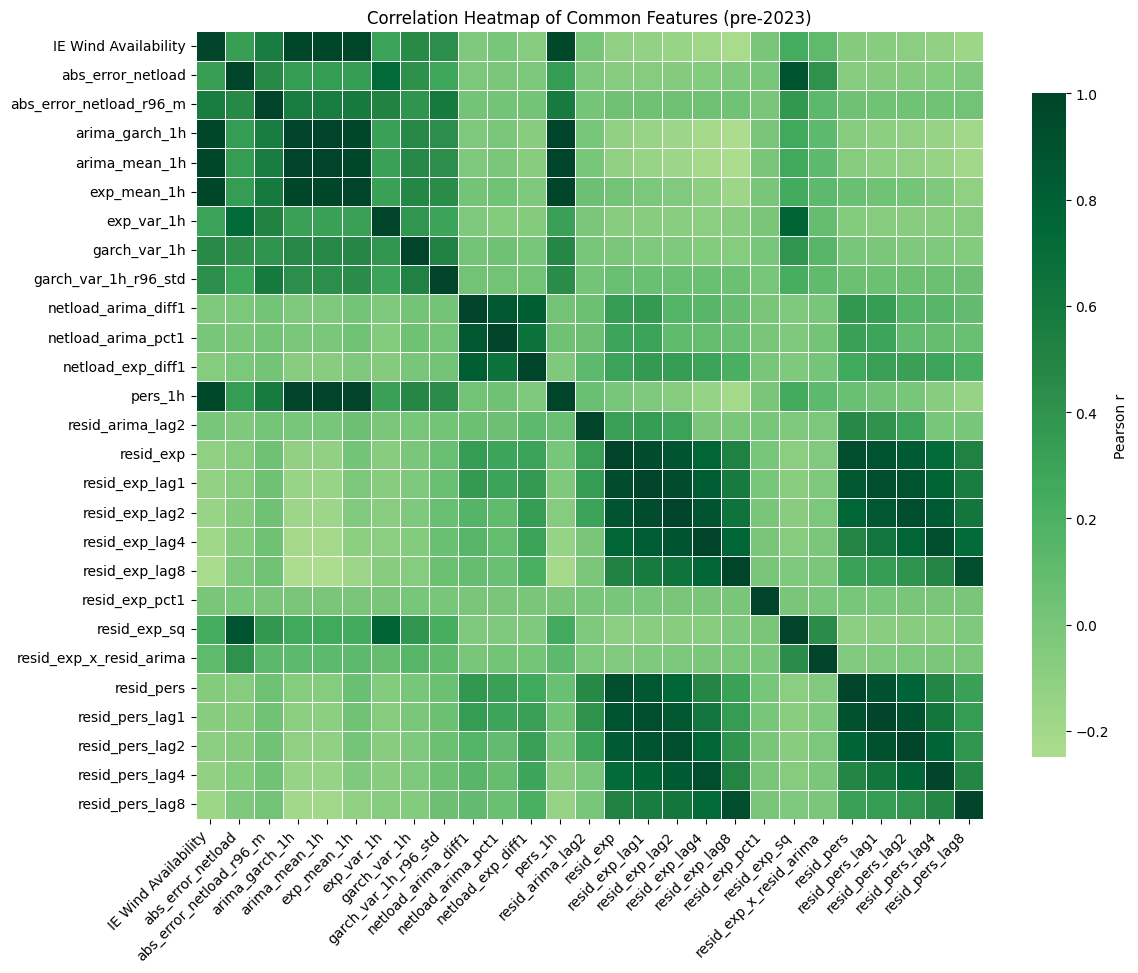

In [ ]:
# Cell: Correlation heatmap of common features (pre-2023) with green-to-yellow colormap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define pre-2023 mask and select only the common features
train_mask = df_feat.index < "2023-01-01"
df_common  = (
    df_feat
    .loc[train_mask, common_feats]
    .replace([np.inf, -np.inf], np.nan)
    .dropna(how='any')
)

# 2) Compute Pearson correlation matrix
corr = df_common.corr()

# 3) Plot heatmap with green-to-yellow colormap
plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    cmap="YlGn",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Pearson r"}
)
plt.title("Correlation Heatmap of Common Features (pre-2023)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Cell: Small grid‑search OC‑SVM (sanity check) on top common features

import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score

# 0) Define the  common feature set from MI & RF overlap


# 1) Prepare training slice
train_mask = df_feat.index < "2023-01-01"
X_train = df_feat.loc[train_mask, common_feats].copy()
y_train = df_feat.loc[train_mask, 'anom_sigma'].values

# 2) Replace infinities and impute missing
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
imp = SimpleImputer(strategy='mean')
X_imp = imp.fit_transform(X_train)

# 3) Scale
scaler = StandardScaler()
X_all = scaler.fit_transform(X_imp)

# 4) Define your custom lex scorer
def lex_scorer(y_true, y_pred):
    flags = (y_pred == -1).astype(int)
    rec   = recall_score(y_true, flags, zero_division=0)
    prec  = precision_score(y_true, flags, zero_division=0)
    return prec if (rec >= 0.70 and prec >= 0.50) else (rec - 1.0)

lex_score = make_scorer(lex_scorer, greater_is_better=True)

# 5) Anomaly‑safe time‑series splitter
splitter = AnomalySafeTimeSeriesSplit(
    n_splits=5,
    min_anomalies=5,
    max_multiplier=2
)

# 6) Parameter grid & GridSearch
param_grid = {
    'nu':        [0.01, 0.1],
    'gamma':     ['scale', 'auto'],
    'shrinking': [True, False],
    'kernel':    ['rbf']
}

grid = GridSearchCV(
    OneClassSVM(),
    param_grid=param_grid,
    scoring=lex_score,
    cv=splitter,
    refit=True,
    n_jobs=12,
    return_train_score=True
)
grid.fit(X_all, y_train)

# 7) Report best result
print("Best params:", grid.best_params_)
print("CV lex_score (rec ≥ 0.70 & prec ≥ 0.50):", grid.best_score_)

Best params: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1, 'shrinking': True}
CV lex_score (rec ≥ 0.70 & prec ≥ 0.50): 0.0


In [ ]:
# Cell: Evaluate best OC‑SVM on 2023–24 hold‑out

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Prepare hold‑out slice
hold_mask = df_feat.index >= "2023-01-01"
X_hold = df_feat.loc[hold_mask, common_feats].copy()
y_hold = df_feat.loc[hold_mask, 'anom_sigma'].values

# 2) Replace ±inf and impute with the existing imputer
X_hold.replace([np.inf, -np.inf], np.nan, inplace=True)
X_hold_imp = imp.transform(X_hold)          # reuse SimpleImputer from grid cell

# 3) Scale with the existing scaler
X_hold_scaled = scaler.transform(X_hold_imp)  # reuse StandardScaler from grid cell

# 4) Predict with the best model
best_ocsvm = grid.best_estimator_
y_pred_raw = best_ocsvm.predict(X_hold_scaled)
y_pred = (y_pred_raw == -1).astype(int)

# 5) Compute precision, recall, F1
prec = precision_score(y_hold, y_pred, zero_division=0)
rec  = recall_score(   y_hold, y_pred, zero_division=0)
f1   = f1_score(      y_hold, y_pred, zero_division=0)

print(f"Hold‑out — Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

Hold‑out — Precision: 0.712, Recall: 1.000, F1: 0.832


In [ ]:
# Cell: DeepSVDD hyperparameter tuning on pre‑2023 data with anomaly‑safe CV (2–4 hidden layers)

import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pyod.models.deep_svdd import DeepSVDD

# 1) Prepare features & labels

train_mask = df_feat.index < "2023-01-01"
X = df_feat.loc[train_mask, common_feats].replace([np.inf, -np.inf], np.nan)
y = df_feat.loc[train_mask, 'anom_sigma'].values

# 2) Impute missing and scale
imp    = SimpleImputer(strategy='mean')
X_imp  = imp.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 3) Custom lexicographic scorer
def lex_scorer(y_true, y_pred):
    rec  = recall_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    return prec if (rec >= 0.70 and prec >= 0.50) else (rec - 1.0)

# 4) Hyperparameter grid: only 2, 3 and 4 hidden layers
param_grid = {
    'hidden_neurons': [
        [128, 64],           # 2 layers
        [128, 64, 32],       # 3 layers
        [256, 128, 64, 32],  # 4 layers
    ],
    'contamination': [0.01, 0.05],
    'epochs': [20, 50]
}

# 5) Anomaly‑safe time‑series splitter
splitter = AnomalySafeTimeSeriesSplit(
    n_splits=5,
    min_anomalies=5,
    max_multiplier=2
)

best_score  = -np.inf
best_params = None
n_feats     = X_scaled.shape[1]

# 6) Manual grid‑search using anomaly‑safe folds
for params in ParameterGrid(param_grid):
    fold_scores = []
    for tr_idx, te_idx in splitter.split(X_scaled, y):
        model = DeepSVDD(n_features=n_feats, **params)
        model.fit(X_scaled[tr_idx])
        thr    = np.percentile(model.decision_scores_, 100 * (1 - params['contamination']))
        y_pred = (model.decision_function(X_scaled[te_idx]) > thr).astype(int)
        fold_scores.append(lex_scorer(y[te_idx], y_pred))
    mean_score = np.mean(fold_scores)
    if mean_score > best_score:
        best_score, best_params = mean_score, params

print(f"Best lex_score (CV): {best_score:.4f}")
print(f"Best DeepSVDD params: {best_params}")

Epoch 1/20, Loss: 1285.6260433793068
Epoch 2/20, Loss: 1285.5490726828575
Epoch 3/20, Loss: 1285.558174431324
Epoch 4/20, Loss: 1285.6419324874878
Epoch 5/20, Loss: 1285.5361531376839
Epoch 6/20, Loss: 1285.5416700839996
Epoch 7/20, Loss: 1285.6041105985641
Epoch 8/20, Loss: 1285.5704846978188
Epoch 9/20, Loss: 1285.6340563893318
Epoch 10/20, Loss: 1285.5587867498398
Epoch 11/20, Loss: 1285.566766321659
Epoch 12/20, Loss: 1285.56925034523
Epoch 13/20, Loss: 1285.5497876405716
Epoch 14/20, Loss: 1285.643802523613
Epoch 15/20, Loss: 1285.5505210757256
Epoch 16/20, Loss: 1285.5431107878685
Epoch 17/20, Loss: 1285.603465974331
Epoch 18/20, Loss: 1285.6045582294464
Epoch 19/20, Loss: 1285.6297018527985
Epoch 20/20, Loss: 1285.6078167557716
Epoch 1/20, Loss: 3162.5725603699684
Epoch 2/20, Loss: 3162.3639985919
Epoch 3/20, Loss: 3162.365418076515
Epoch 4/20, Loss: 3162.8903014063835
Epoch 5/20, Loss: 3162.072907269001
Epoch 6/20, Loss: 3162.2644163370132
Epoch 7/20, Loss: 3162.411542057991
Ep

In [ ]:
# Cell: Evaluate best DeepSVDD on 2023–holdout

from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Prepare hold‑out features & labels
hold_mask = df_feat.index >= "2023-01-01"
X_hold = df_feat.loc[hold_mask, common_feats].replace([np.inf, -np.inf], np.nan)
y_hold = df_feat.loc[hold_mask, 'anom_sigma'].values

# 2) Impute & scale using the training transformers
X_hold_imp    = imp.transform(X_hold)
X_hold_scaled = scaler.transform(X_hold_imp)

# 3) Fit final model on full pre‑2023 data
svdd_final = DeepSVDD(n_features=n_feats, **best_params)
svdd_final.fit(X_scaled)

# 4) Compute threshold from training scores
thr = np.percentile(svdd_final.decision_scores_, 100 * (1 - best_params['contamination']))

# 5) Predict hold‑out anomalies
y_hold_pred = (svdd_final.decision_function(X_hold_scaled) > thr).astype(int)

# 6) Compute & print metrics
rec   = recall_score(y_hold, y_hold_pred, zero_division=0)
prec  = precision_score(y_hold, y_hold_pred, zero_division=0)
f1    = f1_score(y_hold, y_hold_pred, zero_division=0)

print(f"Hold‑out Recall : {rec:.3f}")
print(f"Hold‑out Precision: {prec:.3f}")
print(f"Hold‑out F1      : {f1:.3f}")

Epoch 1/20, Loss: 19199.399825811386
Epoch 2/20, Loss: 19199.292155504227
Epoch 3/20, Loss: 19199.360990345478
Epoch 4/20, Loss: 19199.652330756187
Epoch 5/20, Loss: 19199.445637106895
Epoch 6/20, Loss: 19199.407635986805
Epoch 7/20, Loss: 19199.50346326828
Epoch 8/20, Loss: 19199.313783288002
Epoch 9/20, Loss: 19199.593625187874
Epoch 10/20, Loss: 19199.37888920307
Epoch 11/20, Loss: 19199.67347818613
Epoch 12/20, Loss: 19199.277725338936
Epoch 13/20, Loss: 19199.318319380283
Epoch 14/20, Loss: 19199.359873116016
Epoch 15/20, Loss: 19199.303594350815
Epoch 16/20, Loss: 19199.59225422144
Epoch 17/20, Loss: 19199.436179995537
Epoch 18/20, Loss: 19199.62338221073
Epoch 19/20, Loss: 19199.34875369072
Epoch 20/20, Loss: 19199.496897876263
Hold‑out Recall : 1.000
Hold‑out Precision: 0.770
Hold‑out F1      : 0.870


In [ ]:
# Cell: Save trained models & preprocessors to disk with timestamp
import joblib
from datetime import datetime

# Create timestamp string: YYYYMMDD_HHMMSS
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1) Save best OC-SVM
ocsvm_filename = f"best_ocsvm_{timestamp}.joblib"
joblib.dump(best_ocsvm, ocsvm_filename)
print(f"Saved OC-SVM → {ocsvm_filename}")

# 2) Save final DeepSVDD
svdd_filename = f"best_deepsvdd_{timestamp}.joblib"
joblib.dump(svdd_final, svdd_filename)
print(f"Saved DeepSVDD → {svdd_filename}")

# 3) Save your imputer & scaler
imp_filename    = f"preprocessor_imputer_{timestamp}.joblib"
scaler_filename = f"preprocessor_scaler_{timestamp}.joblib"

joblib.dump(imp,    imp_filename)
joblib.dump(scaler, scaler_filename)
print(f"Saved preprocessing → {imp_filename}, {scaler_filename}")

Saved OC-SVM → best_ocsvm_20250811_085757.joblib
Saved DeepSVDD → best_deepsvdd_20250811_085757.joblib
Saved preprocessing → preprocessor_imputer_20250811_085757.joblib, preprocessor_scaler_20250811_085757.joblib


In [ ]:
'''import joblib
import glob
import os

def load_latest(pattern):
    """Load the most recent file matching a pattern."""
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No files match pattern: {pattern}")
    latest_file = max(files, key=os.path.getmtime)
    print(f"Loaded: {latest_file}")
    return joblib.load(latest_file)

# Load the latest timestamped files
best_ocsvm = load_latest("best_ocsvm_*.joblib")
svdd_final = load_latest("best_deepsvdd_*.joblib")
imp        = load_latest("preprocessor_imputer_*.joblib")
scaler     = load_latest("preprocessor_scaler_*.joblib")'''

In [ ]:
# Cell: σ‑threshold CV metrics
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Build univariate array & labels
train_mask = df_feat.index < "2023-01-01"
resid = df_feat.loc[train_mask, 'resid_exp'] \
             .replace([np.inf, -np.inf], np.nan) \
             .fillna(0).values
y      = df_feat.loc[train_mask, 'anom_sigma'].values

# 2) Anomaly‑safe splitter (reuse from your notebook)
splitter = AnomalySafeTimeSeriesSplit(n_splits=5, min_anomalies=5, max_multiplier=2)

precisions, recalls, f1s = [], [], []
for tr_idx, te_idx in splitter.split(resid.reshape(-1,1), y):
    # compute σ on train slice
    sigma_tr = np.std(resid[tr_idx])
    # flag > 3·σ in test slice
    y_pred = (np.abs(resid[te_idx]) > 3 * sigma_tr).astype(int)
    y_true = y[te_idx]
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(   recall_score(   y_true, y_pred, zero_division=0))
    f1s.append(       f1_score(       y_true, y_pred, zero_division=0))

print("σ‑threshold CV:")
print(f"  Precision: {np.mean(precisions):.3f} ± {np.std(precisions):.3f}")
print(f"  Recall   : {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"  F1       : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

σ‑threshold CV:
  Precision: 0.196 ± 0.108
  Recall   : 1.000 ± 0.000
  F1       : 0.315 ± 0.144


In [ ]:
# Cell: IsolationForest (univariate) CV metrics
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Build univariate array & labels
train_mask = df_feat.index < "2023-01-01"
X_uni = df_feat.loc[train_mask, 'resid_exp'] \
               .replace([np.inf, -np.inf], np.nan) \
               .fillna(0).values.reshape(-1,1)
y     = df_feat.loc[train_mask, 'anom_sigma'].values

# 2) Split & evaluate
precisions, recalls, f1s = [], [], []
for tr_idx, te_idx in splitter.split(X_uni, y):
    model = IsolationForest(contamination=0.05, random_state=SEED)
    model.fit(X_uni[tr_idx])
    y_pred = (model.predict(X_uni[te_idx]) == -1).astype(int)
    y_true = y[te_idx]
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(   recall_score(   y_true, y_pred, zero_division=0))
    f1s.append(       f1_score(       y_true, y_pred, zero_division=0))

print("IsolationForest (univariate) CV:")
print(f"  Precision: {np.mean(precisions):.3f} ± {np.std(precisions):.3f}")
print(f"  Recall   : {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"  F1       : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

IsolationForest (univariate) CV:
  Precision: 0.068 ± 0.040
  Recall   : 1.000 ± 0.000
  F1       : 0.125 ± 0.069


In [ ]:
# Cell: IsolationForest (multivariate) CV metrics
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Build multivariate matrix & labels
train_mask = df_feat.index < "2023-01-01"
X_multi = df_feat.loc[train_mask, common_feats] \
                   .replace([np.inf, -np.inf], np.nan) \
                   .fillna(df_feat[common_feats].median()).values
y       = df_feat.loc[train_mask, 'anom_sigma'].values

# 2) Split & evaluate
precisions, recalls, f1s = [], [], []
for tr_idx, te_idx in splitter.split(X_multi, y):
    model = IsolationForest(contamination=0.05, random_state=SEED)
    model.fit(X_multi[tr_idx])
    y_pred = (model.predict(X_multi[te_idx]) == -1).astype(int)
    y_true = y[te_idx]
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(   recall_score(   y_true, y_pred, zero_division=0))
    f1s.append(       f1_score(       y_true, y_pred, zero_division=0))

print("IsolationForest (multivariate) CV:")
print(f"  Precision: {np.mean(precisions):.3f} ± {np.std(precisions):.3f}")
print(f"  Recall   : {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"  F1       : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")


IsolationForest (multivariate) CV:
  Precision: 0.052 ± 0.029
  Recall   : 1.000 ± 0.000
  F1       : 0.098 ± 0.052


In [ ]:
# Cell: Compute False Alarm Rates for all detectors

import numpy as np
from sklearn.ensemble import IsolationForest

# Re‑instantiate splitter
splitter = AnomalySafeTimeSeriesSplit(n_splits=5, min_anomalies=5, max_multiplier=2)

# Hold‑out masks & data (for OC‑SVM & DeepSVDD)
hold_mask = df_feat.index >= "2023-01-01"
X_hold      = df_feat.loc[hold_mask, common_feats].replace([np.inf, -np.inf], np.nan)
X_hold_imp  = imp.transform(X_hold)
X_hold_scl  = scaler.transform(X_hold_imp)
y_hold      = df_feat.loc[hold_mask, 'anom_sigma'].values

# 1) OC‑SVM hold‑out false‑alarm rate
y_pred_ocsvm = (best_ocsvm.predict(X_hold_scl) == -1).astype(int)
fa_ocsvm = np.mean(y_pred_ocsvm[y_hold == 0])
# 2) DeepSVDD hold‑out false‑alarm rate
svdd_final = DeepSVDD(n_features=n_feats, **best_params).fit(X_scaled)
thr_svdd   = np.percentile(svdd_final.decision_scores_, 100 * (1 - best_params['contamination']))
y_pred_svdd = (svdd_final.decision_function(X_hold_scl) > thr_svdd).astype(int)
fa_svdd = np.mean(y_pred_svdd[y_hold == 0])

# 3) σ‑threshold CV false‑alarm rate
resid = df_feat.loc[df_feat.index < "2023-01-01", 'resid_exp'] \
             .replace([np.inf, -np.inf], np.nan).fillna(0).values
y_cv  = df_feat.loc[df_feat.index < "2023-01-01", 'anom_sigma'].values
fa_sigma = []
for tr, te in splitter.split(resid.reshape(-1,1), y_cv):
    σ = np.std(resid[tr])
    y_p = (np.abs(resid[te]) > 3*σ).astype(int)
    fa_sigma.append(np.mean(y_p[y_cv[te]==0]))
fa_sigma = np.mean(fa_sigma)

# 4) IsolationForest (univariate) CV false‑alarm rate
X_uni = df_feat.loc[df_feat.index < "2023-01-01", 'resid_exp'] \
               .replace([np.inf, -np.inf], np.nan).fillna(0).values.reshape(-1,1)
fa_if_uni = []
for tr, te in splitter.split(X_uni, y_cv):
    m = IsolationForest(contamination=0.05, random_state=SEED).fit(X_uni[tr])
    y_p = (m.predict(X_uni[te]) == -1).astype(int)
    fa_if_uni.append(np.mean(y_p[y_cv[te]==0]))
fa_if_uni = np.mean(fa_if_uni)

# 5) IsolationForest (multivariate) CV false‑alarm rate
X_mul = df_feat.loc[df_feat.index < "2023-01-01", common_feats] \
               .replace([np.inf, -np.inf], np.nan) \
               .fillna(df_feat[common_feats].median()).values
fa_if_mul = []
for tr, te in splitter.split(X_mul, y_cv):
    m = IsolationForest(contamination=0.05, random_state=SEED).fit(X_mul[tr])
    y_p = (m.predict(X_mul[te]) == -1).astype(int)
    fa_if_mul.append(np.mean(y_p[y_cv[te]==0]))
fa_if_mul = np.mean(fa_if_mul)

# Report
print("False‑Alarm Rates:")
print(f" OC‑SVM (hold‑out):       {fa_ocsvm:.3f}")
print(f" DeepSVDD (hold‑out):     {fa_svdd:.3f}")
print(f" σ‑threshold (CV mean):   {fa_sigma:.3f}")
print(f" IF (univariate CV mean): {fa_if_uni:.3f}")
print(f" IF (multivariate CV mean): {fa_if_mul:.3f}")

Epoch 1/20, Loss: 12602.774338632822
Epoch 2/20, Loss: 12602.867319226265
Epoch 3/20, Loss: 12602.930447340012
Epoch 4/20, Loss: 12602.775657594204
Epoch 5/20, Loss: 12603.309947252274
Epoch 6/20, Loss: 12602.893667846918
Epoch 7/20, Loss: 12602.871299684048
Epoch 8/20, Loss: 12602.854378402233
Epoch 9/20, Loss: 12602.720169723034
Epoch 10/20, Loss: 12603.045663714409
Epoch 11/20, Loss: 12602.796354174614
Epoch 12/20, Loss: 12602.806584894657
Epoch 13/20, Loss: 12602.814052164555
Epoch 14/20, Loss: 12602.798431277275
Epoch 15/20, Loss: 12602.784493297338
Epoch 16/20, Loss: 12602.944846600294
Epoch 17/20, Loss: 12602.701461613178
Epoch 18/20, Loss: 12602.994319945574
Epoch 19/20, Loss: 12602.802024036646
Epoch 20/20, Loss: 12602.673374593258
False‑Alarm Rates:
 OC‑SVM (hold‑out):       0.912
 DeepSVDD (hold‑out):     0.684
 σ‑threshold (CV mean):   0.023
 IF (univariate CV mean): 0.079
 IF (multivariate CV mean): 0.103


In [ ]:
# Cell: Assemble final detector metrics into DataFrame

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest

# 1) Hold‑out data & labels
hold_mask = df_feat.index >= "2023-01-01"
X_hold      = df_feat.loc[hold_mask, common_feats].replace([np.inf, -np.inf], np.nan)
X_hold_imp  = imp.transform(X_hold)
X_hold_scl  = scaler.transform(X_hold_imp)
y_hold      = df_feat.loc[hold_mask, 'anom_sigma'].values

# OC‑SVM hold‑out preds & metrics
y_pred_ocsvm = (best_ocsvm.predict(X_hold_scl) == -1).astype(int)
prec_ocsvm   = precision_score(y_hold, y_pred_ocsvm, zero_division=0)
rec_ocsvm    = recall_score(   y_hold, y_pred_ocsvm, zero_division=0)
f1_ocsvm     = f1_score(       y_hold, y_pred_ocsvm, zero_division=0)
fa_ocsvm     = np.mean(y_pred_ocsvm[y_hold == 0])

# DeepSVDD hold‑out preds & metrics
thr_svdd     = np.percentile(svdd_final.decision_scores_, 100 * (1 - best_params['contamination']))
y_pred_svdd  = (svdd_final.decision_function(X_hold_scl) > thr_svdd).astype(int)
prec_svdd    = precision_score(y_hold, y_pred_svdd, zero_division=0)
rec_svdd     = recall_score(   y_hold, y_pred_svdd, zero_division=0)
f1_svdd      = f1_score(       y_hold, y_pred_svdd, zero_division=0)
fa_svdd      = np.mean(y_pred_svdd[y_hold == 0])

# 2) CV data & labels (pre‑2023)
train_mask = df_feat.index < "2023-01-01"
resid      = df_feat.loc[train_mask, 'resid_exp'].replace([np.inf, -np.inf], np.nan).fillna(0).values
X_uni      = resid.reshape(-1,1)
X_mul      = df_feat.loc[train_mask, common_feats] \
                  .replace([np.inf, -np.inf], np.nan) \
                  .fillna(df_feat[common_feats].median()).values
y_cv       = df_feat.loc[train_mask, 'anom_sigma'].values

splitter = AnomalySafeTimeSeriesSplit(n_splits=5, min_anomalies=5, max_multiplier=2)

# sigma‑threshold CV metrics
ps, rs, fs, fas = [], [], [], []
for tr, te in splitter.split(resid.reshape(-1,1), y_cv):
    σ = np.std(resid[tr])
    pred = (np.abs(resid[te]) > 3*σ).astype(int)
    true = y_cv[te]
    ps.append(precision_score(true, pred, zero_division=0))
    rs.append(recall_score(   true, pred, zero_division=0))
    fs.append(f1_score(       true, pred, zero_division=0))
    fas.append(np.mean(pred[true == 0]))
prec_sigma, rec_sigma, f1_sigma, fa_sigma = np.mean(ps), np.mean(rs), np.mean(fs), np.mean(fas)

# IsolationForest (univariate) CV metrics
ps, rs, fs, fas = [], [], [], []
for tr, te in splitter.split(X_uni, y_cv):
    m = IsolationForest(contamination=0.05, random_state=SEED).fit(X_uni[tr])
    pred = (m.predict(X_uni[te]) == -1).astype(int)
    true = y_cv[te]
    ps.append(precision_score(true, pred, zero_division=0))
    rs.append(recall_score(   true, pred, zero_division=0))
    fs.append(f1_score(       true, pred, zero_division=0))
    fas.append(np.mean(pred[true == 0]))
prec_if_uni, rec_if_uni, f1_if_uni, fa_if_uni = np.mean(ps), np.mean(rs), np.mean(fs), np.mean(fas)

# IsolationForest (multivariate) CV metrics
ps, rs, fs, fas = [], [], [], []
for tr, te in splitter.split(X_mul, y_cv):
    m = IsolationForest(contamination=0.05, random_state=SEED).fit(X_mul[tr])
    pred = (m.predict(X_mul[te]) == -1).astype(int)
    true = y_cv[te]
    ps.append(precision_score(true, pred, zero_division=0))
    rs.append(recall_score(   true, pred, zero_division=0))
    fs.append(f1_score(       true, pred, zero_division=0))
    fas.append(np.mean(pred[true == 0]))
prec_if_mul, rec_if_mul, f1_if_mul, fa_if_mul = np.mean(ps), np.mean(rs), np.mean(fs), np.mean(fas)

# 3) Assemble into DataFrame
df_detector_metrics2 = pd.DataFrame([
    {
        'Method':          'OC‑SVM',
        'FalseAlarmRate':  fa_ocsvm,
        'Precision':       prec_ocsvm,
        'Recall':          rec_ocsvm,
        'F1':              f1_ocsvm
    },
    {
        'Method':          'DeepSVDD',
        'FalseAlarmRate':  fa_svdd,
        'Precision':       prec_svdd,
        'Recall':          rec_svdd,
        'F1':              f1_svdd
    },
    {
        'Method':          'σ‑Threshold',
        'FalseAlarmRate':  fa_sigma,
        'Precision':       prec_sigma,
        'Recall':          rec_sigma,
        'F1':              f1_sigma
    },
    {
        'Method':          'IsolationForest (univariate)',
        'FalseAlarmRate':  fa_if_uni,
        'Precision':       prec_if_uni,
        'Recall':          rec_if_uni,
        'F1':              f1_if_uni
    },
    {
        'Method':          'IsolationForest (multivariate)',
        'FalseAlarmRate':  fa_if_mul,
        'Precision':       prec_if_mul,
        'Recall':          rec_if_mul,
        'F1':              f1_if_mul
    }
])

df_detector_metrics2

,Method,FalseAlarmRate,Precision,Recall,F1
0,OC‑SVM,0.912116,0.712398,1.0,0.832047
1,DeepSVDD,0.684097,0.767585,1.0,0.868513
2,σ‑Threshold,0.022805,0.196277,1.0,0.315167
3,IsolationForest (univariate),0.078802,0.068090,1.0,0.124908
4,IsolationForest (multivariate),0.103482,0.052347,1.0,0.098019


In [ ]:
print(df_detector_metrics2)

                           Method  FalseAlarmRate  Precision  Recall        F1
0                          OC‑SVM        0.912116   0.712398     1.0  0.832047
1                        DeepSVDD        0.671873   0.770786     1.0  0.870558
2                     σ‑Threshold        0.022805   0.196277     1.0  0.315167
3    IsolationForest (univariate)        0.078802   0.068090     1.0  0.124908
4  IsolationForest (multivariate)        0.103482   0.052347     1.0  0.098019


In [ ]:
# Cell: Build df_plot1 with selected columns
cols_to_copy = [
    'IE Generation', 'IE Demand', 'IE Wind Availability', 'IE Wind Generation',
    'SNSP', 'interconnection', 'NW_temp', 'NW_wdsp', 'NW_wddir',
    'NE_temp', 'NE_wdsp', 'NE_wddir', 'SW_temp', 'SW_wdsp', 'SW_wddir',
    'SE_temp', 'SE_wdsp', 'SE_wddir', 'Net_load', 'pers_1h',
    'arima_mean_1h', 'garch_var_1h', 'arima_garch_1h',
    'exp_mean_1h', 'exp_var_1h', 'resid_pers', 'resid_arima', 'resid_exp',
    'anom_ocsvm', 'anom_svdd', 'anom_sigma', 'anom_if',
    'is_weekend', 'is_holiday', 'is_month_end', 'is_quarter_start', 'is_year_end',
    'regime_shift',
    'anom_sigma_flag', 'anom_sigma_flag_r96_sum',
    'anom_if_flag', 'anom_if_flag_r96_sum',
    'anom_ocsvm_flag', 'anom_ocsvm_flag_r96_sum',
    'anom_svdd_flag', 'anom_svdd_flag_r96_sum'
]

df_plot1 = df_feat[cols_to_copy].copy()

In [ ]:
# Cell: Compute and store OC-SVM & DeepSVDD decision scores without touching original df_feat

# 1) Copy df_feat so we don’t modify the master DataFrame
df_temp = df_feat.copy()

# 2) Define hold-out mask
hold_mask = df_temp.index >= "2023-01-01"

# 3) Select only the features you trained on
X_hold = df_temp.loc[hold_mask, common_feats]

# 4) Clean infinities → NaN
X_hold = X_hold.replace([np.inf, -np.inf], np.nan)

# 5) Impute missing values with saved imputer
X_hold_imp = imp.transform(X_hold)

# 6) Scale features with saved scaler
X_hold_scaled = scaler.transform(X_hold_imp)

# 7) Compute decision function scores
scores_ocsvm = best_ocsvm.decision_function(X_hold_scaled)
scores_svdd  = svdd_final.decision_function(X_hold_scaled)

# 8) Assign scores into your plotting DataFrame
df_plot1.loc[hold_mask, 'score_ocsvm'] = scores_ocsvm
df_plot1.loc[hold_mask, 'score_svdd']  = scores_svdd

In [ ]:
# Cell: Compute precision–recall sweeps for OC-SVM and DeepSVDD, store in df_plot1

from sklearn.metrics import precision_recall_curve

# Step A: define hold-out mask (reuse df_feat index)
hold_mask = df_feat.index >= "2023-01-01"

# Step B: pull true labels once
y_true = df_plot1.loc[hold_mask, 'anom_sigma']

# OC-SVM precision–recall
scores_ocsvm = df_plot1.loc[hold_mask, 'score_ocsvm']
prec_ocsvm, rec_ocsvm, thr_ocsvm = precision_recall_curve(y_true, scores_ocsvm)
df_prc_ocsvm = pd.DataFrame({
    'precision': prec_ocsvm,
    'recall':    rec_ocsvm,
    'threshold': list(thr_ocsvm) + [None]
}, index=range(len(prec_ocsvm)))
df_plot1.attrs['pr_curve_ocsvm'] = df_prc_ocsvm

# DeepSVDD precision–recall
scores_svdd = df_plot1.loc[hold_mask, 'score_svdd']
prec_svdd, rec_svdd, thr_svdd = precision_recall_curve(y_true, scores_svdd)
df_prc_svdd = pd.DataFrame({
    'precision': prec_svdd,
    'recall':    rec_svdd,
    'threshold': list(thr_svdd) + [None]
}, index=range(len(prec_svdd)))
df_plot1.attrs['pr_curve_svdd'] = df_prc_svdd

In [ ]:
# Cell: Compute confusion‐matrix counts for OC-SVM at threshold 0

from sklearn.metrics import confusion_matrix

# Step A: define hold-out mask
hold_mask = df_plot1.index >= "2023-01-01"

# Step B: true labels and OC-SVM scores
y_true = df_plot1.loc[hold_mask, 'anom_sigma']
scores = df_plot1.loc[hold_mask, 'score_ocsvm']

# Step C: apply threshold
thresh = 0.0
y_pred = (scores > thresh).astype(int)

# Step D: compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Step E: store in df_plot1 metadata for later use
df_plot1.attrs['cm_ocsvm'] = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

print(f"OC-SVM @ thresh {thresh}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

OC-SVM @ thresh 0.0: TP=0, FP=2200, FN=56558, TN=22833


In [ ]:
# Cell: Compute confusion‐matrix counts for DeepSVDD at threshold 0

from sklearn.metrics import confusion_matrix

# Step A: define hold-out mask
hold_mask = df_plot1.index >= "2023-01-01"

# Step B: true labels and DeepSVDD scores
y_true = df_plot1.loc[hold_mask, 'anom_sigma']
scores = df_plot1.loc[hold_mask, 'score_svdd']

# Step C: apply threshold
thresh = 0.0
y_pred = (scores > thresh).astype(int)

# Step D: compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Step E: store in df_plot1 metadata for later use
df_plot1.attrs['cm_svdd'] = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

print(f"DeepSVDD @ thresh {thresh}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

DeepSVDD @ thresh 0.0: TP=56558, FP=25033, FN=0, TN=0


In [ ]:
# Cell: Compute ROC curve data for OC-SVM and DeepSVDD

from sklearn.metrics import roc_curve

# Step A: define hold-out mask
hold_mask = df_plot1.index >= "2023-01-01"

# Step B: true labels
y_true = df_plot1.loc[hold_mask, 'anom_sigma']

# OC-SVM ROC data
scores_ocsvm = df_plot1.loc[hold_mask, 'score_ocsvm']
fpr_ocsvm, tpr_ocsvm, roc_thresh_ocsvm = roc_curve(y_true, scores_ocsvm)

# DeepSVDD ROC data
scores_svdd = df_plot1.loc[hold_mask, 'score_svdd']
fpr_svdd, tpr_svdd, roc_thresh_svdd = roc_curve(y_true, scores_svdd)

# Store in df_plot1 attrs for plotting
df_plot1.attrs['roc_ocsvm'] = {
    'fpr': fpr_ocsvm,
    'tpr': tpr_ocsvm,
    'thresholds': roc_thresh_ocsvm
}
df_plot1.attrs['roc_svdd'] = {
    'fpr': fpr_svdd,
    'tpr': tpr_svdd,
    'thresholds': roc_thresh_svdd
}

print("Computed ROC data for OC-SVM and DeepSVDD.")

Computed ROC data for OC-SVM and DeepSVDD.


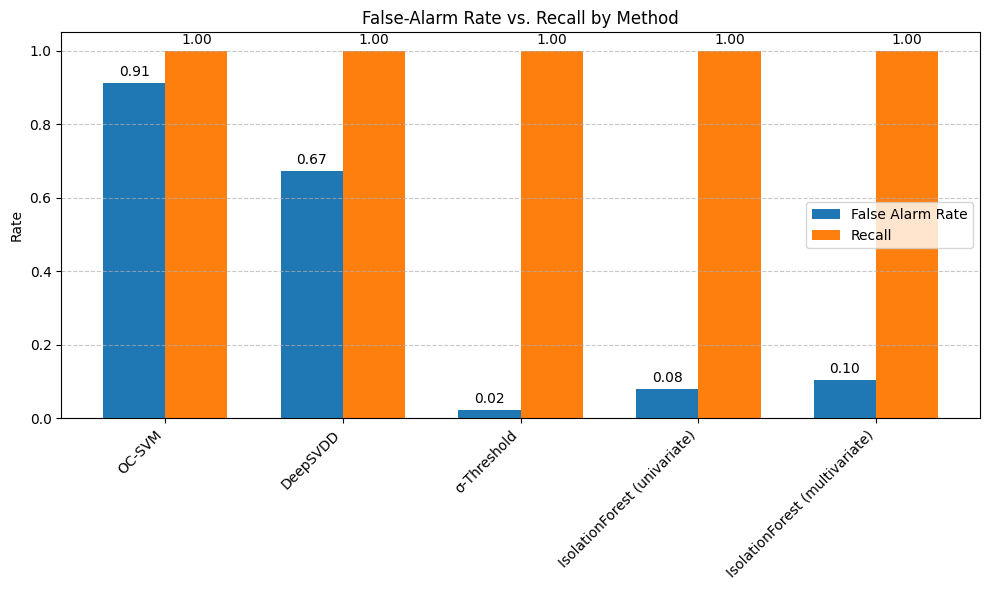

In [ ]:
# Cell: False-Alarm Rate vs. Recall bar chart

import matplotlib.pyplot as plt
import numpy as np

# 1) Prepare data from df_detector_metrics2
methods = df_detector_metrics2['Method']
fa_rates = df_detector_metrics2['FalseAlarmRate']
recalls  = df_detector_metrics2['Recall']

# 2) Set up bar positions
x = np.arange(len(methods))
width = 0.35

# 3) Plot bars
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, fa_rates, width, label='False Alarm Rate')
bars2 = ax.bar(x + width/2, recalls, width, label='Recall')

# 4) Annotate values on bars
for bar in bars1:
    ax.annotate(f"{bar.get_height():.2f}",
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')
for bar in bars2:
    ax.annotate(f"{bar.get_height():.2f}",
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

# 5) Format plot
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.set_ylabel('Rate')
ax.set_title('False-Alarm Rate vs. Recall by Method')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


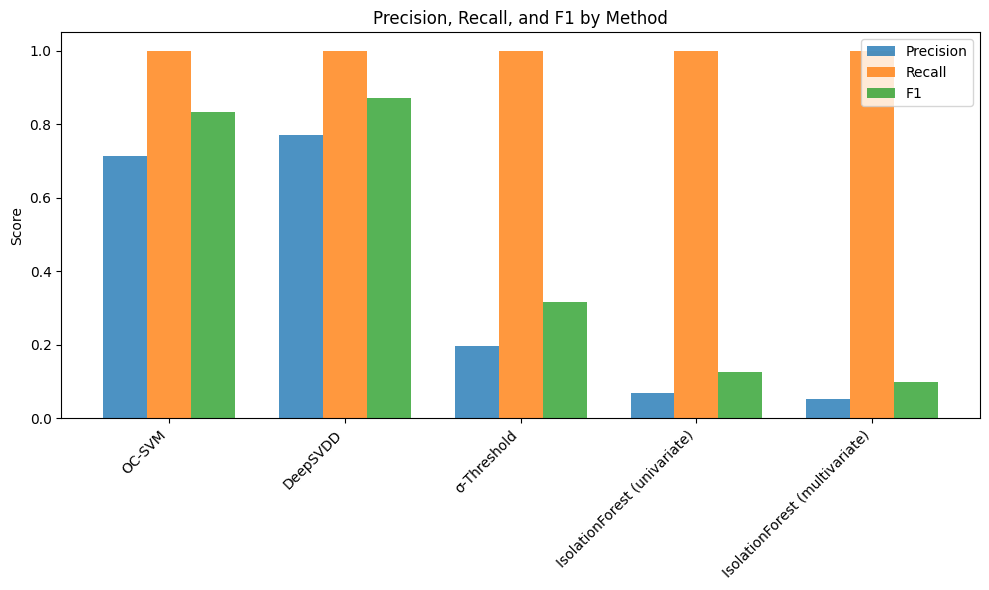

In [ ]:
# Cell: Bar chart of Precision, Recall, and F1 by method

import matplotlib.pyplot as plt
import numpy as np

# Assume df_detector_metrics2 is in scope
methods = df_detector_metrics2['Method']
precisions = df_detector_metrics2['Precision']
recalls = df_detector_metrics2['Recall']
f1s = df_detector_metrics2['F1']

x = np.arange(len(methods))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precisions, width, label='Precision', alpha=0.8)
plt.bar(x, recalls, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1s, width, label='F1', alpha=0.8)

plt.xticks(x, methods, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 by Method')
plt.legend()
plt.tight_layout()
plt.show()


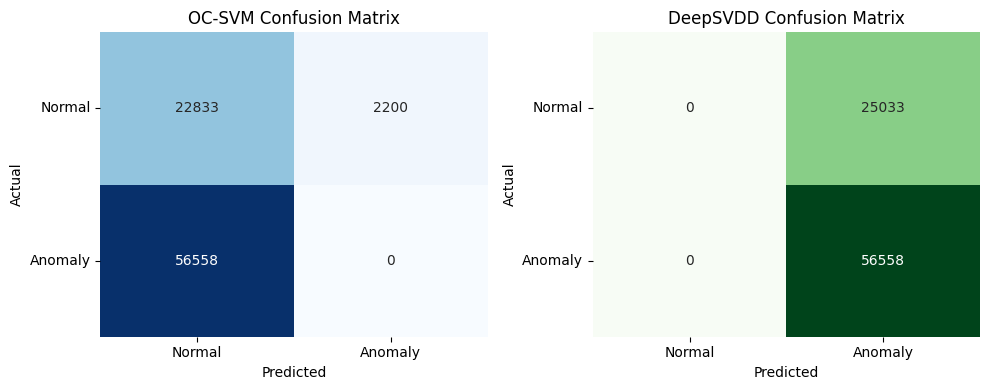

In [ ]:
# Cell: Plot confusion-matrix heatmaps for OC-SVM and DeepSVDD

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Retrieve stored confusion counts
cm_ocsvm = df_plot1.attrs['cm_ocsvm']  # dict with keys 'tn','fp','fn','tp'
cm_svdd  = df_plot1.attrs['cm_svdd']

# Build 2×2 arrays
cm1 = np.array([[cm_ocsvm['tn'], cm_ocsvm['fp']],
                [cm_ocsvm['fn'], cm_ocsvm['tp']]])
cm2 = np.array([[cm_svdd['tn'], cm_svdd['fp']],
                [cm_svdd['fn'], cm_svdd['tp']]])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('OC-SVM Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Normal', 'Anomaly'])
axes[0].set_yticklabels(['Normal', 'Anomaly'], rotation=0)

sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('DeepSVDD Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Normal', 'Anomaly'])
axes[1].set_yticklabels(['Normal', 'Anomaly'], rotation=0)

plt.tight_layout()
plt.show()

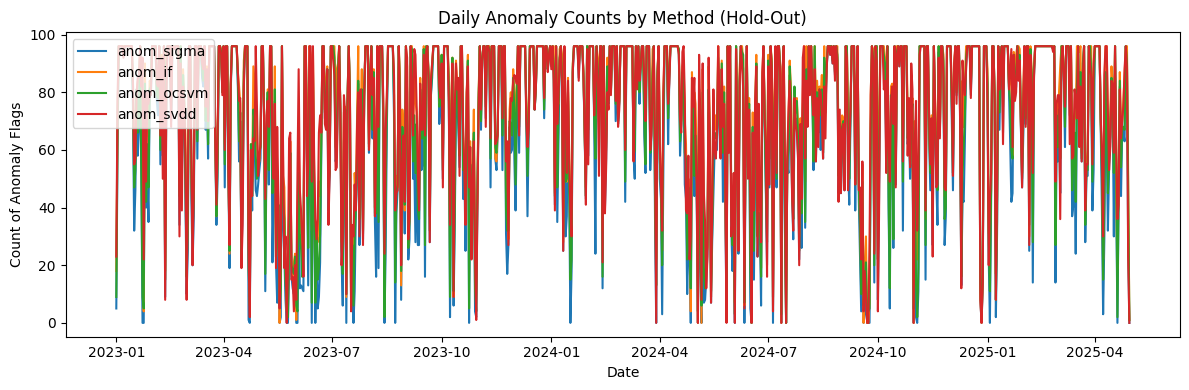

In [ ]:
# Cell: Aggregate daily anomaly‐count timeline for hold-out
import matplotlib.pyplot as plt

# 1) Select hold-out and the four binary flags
hold_mask = df_plot1.index >= "2023-01-01"
flags = ['anom_sigma', 'anom_if', 'anom_ocsvm', 'anom_svdd']
df_daily = (
    df_plot1.loc[hold_mask, flags]
            .resample('D')
            .sum()
)

# 2) Plot each daily count on one chart
plt.figure(figsize=(12,4))
for col in df_daily.columns:
    plt.plot(df_daily.index, df_daily[col], label=col)

plt.legend(loc='upper left')
plt.title("Daily Anomaly Counts by Method (Hold-Out)")
plt.xlabel("Date")
plt.ylabel("Count of Anomaly Flags")
plt.tight_layout()
plt.show()

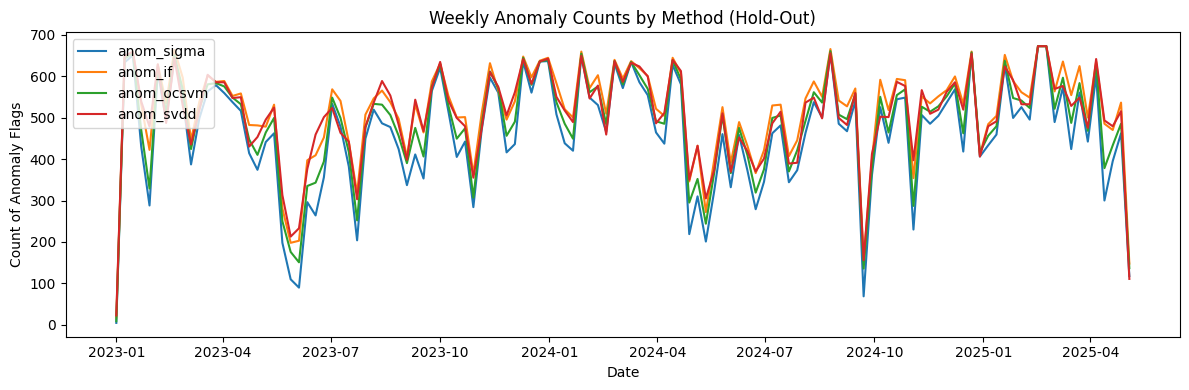

In [ ]:
# Cell: Aggregate weekly anomaly‐count timeline for hold-out
import matplotlib.pyplot as plt

# 1) Select hold-out and the four binary flags
hold_mask = df_plot1.index >= "2023-01-01"
flags = ['anom_sigma', 'anom_if', 'anom_ocsvm', 'anom_svdd']
df_weekly = (
    df_plot1.loc[hold_mask, flags]
            .resample('W')  # weekly frequency
            .sum()
)

# 2) Plot each weekly count on one chart
plt.figure(figsize=(12,4))
for col in df_weekly.columns:
    plt.plot(df_weekly.index, df_weekly[col], label=col)

plt.legend(loc='upper left')
plt.title("Weekly Anomaly Counts by Method (Hold-Out)")
plt.xlabel("Date")
plt.ylabel("Count of Anomaly Flags")
plt.tight_layout()
plt.show()

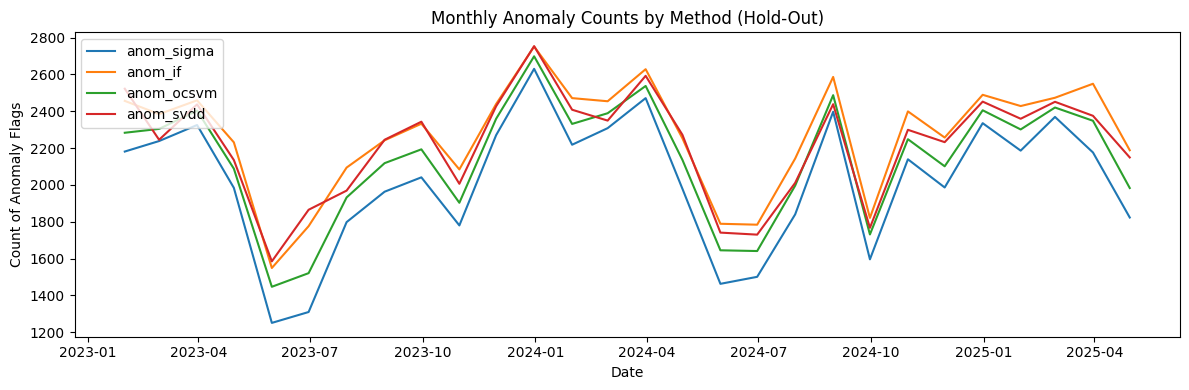

In [ ]:
# Cell: Aggregate monthly anomaly‐count timeline for hold-out (no deprecation warning)
import matplotlib.pyplot as plt

# 1) Select hold-out and the four binary flags
hold_mask = df_plot1.index >= "2023-01-01"
flags = ['anom_sigma', 'anom_if', 'anom_ocsvm', 'anom_svdd']
df_monthly = (
    df_plot1.loc[hold_mask, flags]
            .resample('ME')  # month end frequency
            .sum()
)

# 2) Plot each monthly count on one chart
plt.figure(figsize=(12,4))
for col in df_monthly.columns:
    plt.plot(df_monthly.index, df_monthly[col], label=col)

plt.legend(loc='upper left')
plt.title("Monthly Anomaly Counts by Method (Hold-Out)")
plt.xlabel("Date")
plt.ylabel("Count of Anomaly Flags")
plt.tight_layout()
plt.show()